# Conditional Path Execution with lionagi Flow

This notebook demonstrates how to create conditional workflows using the new flow operation.

In [ ]:
from lionagi.session.session import Session
from lionagi.protocols.graph import Graph, Edge, EdgeCondition
from lionagi.operations.node import Operation

## Example: Conditional Calculator

Let's create a calculator that:
1. Based on a "case" value, either sums or diffs absolute values
2. Based on the result, either multiplies by 2 (if positive) or adds 2 (if negative)

In [2]:
# Create a session and branch with a system message
session = Session()
calc_branch = session.new_branch(
    system="You are asked to perform as a calculator. Return only a numeric value, i.e. int or float, no text."
)
session.default_branch = calc_branch

In [3]:
# Create operations for our workflow

# Operation 1a: Sum absolute values (case 0)
sum_op = Operation(
    operation="chat",
    parameters={
        "instruction": "Given context with 'x' and 'y', return the sum of their absolute values: |x| + |y|"
    },
)

# Operation 1b: Diff absolute values (case 1)
diff_op = Operation(
    operation="chat",
    parameters={
        "instruction": "Given context with 'x' and 'y', return the difference of their absolute values: |x| - |y|"
    },
)

# Operation 2: Apply transformation based on sign
transform_op = Operation(
    operation="chat",
    parameters={
        "instruction": """Given the previous result:
        - If the result is positive (> 0), multiply it by 2
        - If the result is zero or negative (≤ 0), add 2 to it
        Return only the numeric result."""
    },
)

## Define Edge Conditions

In [4]:
# Create condition for case-based branching
class CaseCondition(EdgeCondition):
    def __init__(self, expected_case: int):
        super().__init__()
        self.expected_case = expected_case

    async def apply(self, context: dict) -> bool:
        # Check the case value in the context
        case = context.get("context", {}).get("case", None)
        return case == self.expected_case


# Create conditions
case_0_condition = CaseCondition(expected_case=0)
case_1_condition = CaseCondition(expected_case=1)

## Build the Graph

In [5]:
# Create graph
graph = Graph()

# Add nodes
graph.add_node(sum_op)
graph.add_node(diff_op)
graph.add_node(transform_op)

# We need a start node to make the conditional branching work
# In the new design, we can specify starting_node in flow()
# Or we can add a simple start operation
start_op = Operation(
    operation="chat",
    parameters={
        "instruction": "Acknowledge the input values x and y. Reply 'Ready to calculate.'"
    },
)
graph.add_node(start_op)

# Add conditional edges
graph.add_edge(
    Edge(head=start_op.id, tail=sum_op.id, condition=case_0_condition)
)
graph.add_edge(
    Edge(head=start_op.id, tail=diff_op.id, condition=case_1_condition)
)

# Both paths lead to transform
graph.add_edge(Edge(head=sum_op.id, tail=transform_op.id))
graph.add_edge(Edge(head=diff_op.id, tail=transform_op.id))

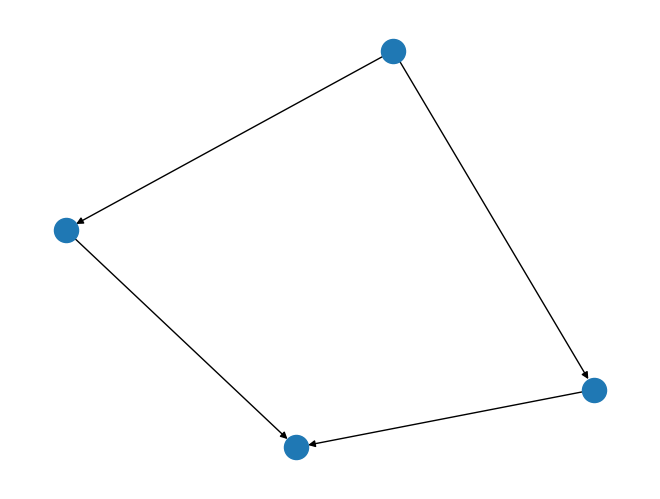

In [6]:
# Visualize the graph
graph.display()

## Execute the Workflow

In [7]:
# Test case 0: Sum absolute values
result_case_0 = await session.flow(
    graph,
    context={"x": -6, "y": 0, "case": 0},
    parallel=True,  # Use parallel execution (now fixed!)
    verbose=True,
)

print("\nCase 0 Results:")
print(f"Completed operations: {result_case_0['completed_operations']}")
print(f"Final result: {result_case_0['operation_results'][transform_op.id]}")

Started operation 9415c403-1efe-47f9-a7de-39ae78366a46 on branch: 6529741d-5c1d-4bea-81d6-e6661487492f
Completed operation: 9415c403-1efe-47f9-a7de-39ae78366a46
Started operation 1969f608-b695-4dfc-80c1-c39992ce45ca on branch: 6529741d-5c1d-4bea-81d6-e6661487492f
Completed operation: 1969f608-b695-4dfc-80c1-c39992ce45ca
Started operation 5171f73b-2c9d-4cb6-94c3-b12a3ca4bacb on branch: 6529741d-5c1d-4bea-81d6-e6661487492f
Completed operation: 5171f73b-2c9d-4cb6-94c3-b12a3ca4bacb
Deadlock detected: 1 nodes cannot execute
Remaining operations: ['chat']

Case 0 Results:
Completed operations: [IDType(9415c403-1efe-47f9-a7de-39ae78366a46), IDType(1969f608-b695-4dfc-80c1-c39992ce45ca), IDType(5171f73b-2c9d-4cb6-94c3-b12a3ca4bacb), IDType(b8784485-568e-4ff2-b83b-9dc916ee528c)]
Final result: 12


In [8]:
# Test case 1: Diff absolute values
result_case_1 = await session.flow(
    graph,
    context={"x": -6, "y": 0, "case": 1},
    parallel=True,  # Use parallel execution (now fixed!)
    verbose=True,
)

print("\nCase 1 Results:")
print(f"Completed operations: {result_case_1['completed_operations']}")
print(f"Final result: {result_case_1['operation_results'][transform_op.id]}")

Started operation 9415c403-1efe-47f9-a7de-39ae78366a46 on branch: 6529741d-5c1d-4bea-81d6-e6661487492f
Completed operation: 9415c403-1efe-47f9-a7de-39ae78366a46
Started operation b8784485-568e-4ff2-b83b-9dc916ee528c on branch: 6529741d-5c1d-4bea-81d6-e6661487492f
Completed operation: b8784485-568e-4ff2-b83b-9dc916ee528c
Started operation 5171f73b-2c9d-4cb6-94c3-b12a3ca4bacb on branch: 6529741d-5c1d-4bea-81d6-e6661487492f
Completed operation: 5171f73b-2c9d-4cb6-94c3-b12a3ca4bacb
Deadlock detected: 1 nodes cannot execute
Remaining operations: ['chat']

Case 1 Results:
Completed operations: [IDType(9415c403-1efe-47f9-a7de-39ae78366a46), IDType(b8784485-568e-4ff2-b83b-9dc916ee528c), IDType(5171f73b-2c9d-4cb6-94c3-b12a3ca4bacb), IDType(1969f608-b695-4dfc-80c1-c39992ce45ca)]
Final result: 12


## View Conversation History

In [9]:
# Convert branch messages to DataFrame for easy viewing
df = calc_branch.to_df()
df[["created_at", "role", "content"]]

,created_at,role,content
0,1.753001e+09,system,{'system_message': 'You are asked to perform a...


## Advanced Example: Multi-Step Conditional Logic

In [10]:
# Create a more complex workflow with multiple conditions
# This example demonstrates nested conditions and parallel paths

# Create new session for this example
from typing import Literal
from pydantic import BaseModel


session2 = Session()
branch2 = session2.new_branch(
    system="You are a helpful assistant that processes data step by step."
)
session2.default_branch = branch2


class DataType(BaseModel):
    data_type: Literal["numeric", "text", "mixed"]
    confidence: float


# Create operations
analyze_op = Operation(
    operation="operate",
    parameters={
        "instruction": "Analyze the input data and classify it as 'numeric', 'text', or 'mixed'",
        "response_format": DataType,
    },
)

# Different processing paths based on data type
numeric_process = Operation(
    operation="chat",
    parameters={
        "instruction": "Calculate statistical summary (mean, median, range) of the numeric data"
    },
)

text_process = Operation(
    operation="chat",
    parameters={
        "instruction": "Provide word count, character count, and identify key themes"
    },
)

mixed_process = Operation(
    operation="ReAct",
    parameters={
        "instruct": {
            "instruction": "Process both numeric and text components separately, then combine insights"
        },
        "max_extensions": 2,
    },
)

# Final summary
summary_op = Operation(
    operation="chat",
    parameters={
        "instruction": "Provide a concise summary of all processing results"
    },
)

# Build graph
complex_graph = Graph()
for op in [
    analyze_op,
    numeric_process,
    text_process,
    mixed_process,
    summary_op,
]:
    complex_graph.add_node(op)


# Define conditions based on analysis results
class DataTypeCondition(EdgeCondition):
    def __init__(self, expected_type: str):
        super().__init__()
        self.expected_type = expected_type

    async def apply(self, context: dict) -> bool:
        # Get the analysis result
        analysis_result = context.get("result", {})
        if isinstance(analysis_result, dict):
            return analysis_result.get("data_type") == self.expected_type
        return False


# Add conditional edges
complex_graph.add_edge(
    Edge(
        head=analyze_op.id,
        tail=numeric_process.id,
        condition=DataTypeCondition("numeric"),
    )
)
complex_graph.add_edge(
    Edge(
        head=analyze_op.id,
        tail=text_process.id,
        condition=DataTypeCondition("text"),
    )
)
complex_graph.add_edge(
    Edge(
        head=analyze_op.id,
        tail=mixed_process.id,
        condition=DataTypeCondition("mixed"),
    )
)

# All paths lead to summary
for process_op in [numeric_process, text_process, mixed_process]:
    complex_graph.add_edge(Edge(head=process_op.id, tail=summary_op.id))

In [11]:
# Test with different data types
test_data = [
    {"data": [1, 2, 3, 4, 5], "description": "numeric data"},
    {
        "data": "The quick brown fox jumps over the lazy dog",
        "description": "text data",
    },
    {
        "data": {"values": [10, 20, 30], "labels": ["A", "B", "C"]},
        "description": "mixed data",
    },
]

for test_case in test_data:
    print(f"\nTesting with {test_case['description']}:")
    result = await session2.flow(
        complex_graph, context={"input_data": test_case["data"]}, verbose=True
    )
    print(f"Summary: {result['operation_results'][summary_op.id]}")


Testing with numeric data:
Started operation d98d4fb6-0da2-4e52-b187-ffb1bac4d2d2 on branch: 81b05ed1-851b-4d1d-94fe-c638a1b2f3da
Completed operation: d98d4fb6-0da2-4e52-b187-ffb1bac4d2d2
Started operation 00a25601-1e93-4b04-a06f-21ab0ef511b4 on branch: 81b05ed1-851b-4d1d-94fe-c638a1b2f3da
Completed operation: 00a25601-1e93-4b04-a06f-21ab0ef511b4
Started operation 7465c7b7-1e5a-4ca9-a4a6-83d921412644 on branch: 81b05ed1-851b-4d1d-94fe-c638a1b2f3da
Completed operation: 7465c7b7-1e5a-4ca9-a4a6-83d921412644
Deadlock detected: 2 nodes cannot execute
Remaining operations: ['ReAct', 'chat']
Summary: # Summary of Processing Results

The input data has been identified and processed to yield statistical information as follows:

1. **Data Type Classification**:
   - Data was classified as `numeric` with high confidence.

2. **Statistical Summary of Numeric Data**:
   - The statistical summary provides insights into the data distribution through key metrics.
   - **Mean**: The average of the dat

## Parallel Execution Example

In [12]:
# Create a workflow that benefits from parallel execution
from lionagi.session import Session

# Create session for multi-branch coordination
session3 = Session()

# Create parallel analysis operations
parallel_ops = [
    Operation(
        operation="chat",
        parameters={"instruction": f"Analyze aspect {i}: {aspect}"},
    )
    for i, aspect in enumerate(
        [
            "Market potential and competitive landscape",
            "Technical feasibility and implementation challenges",
            "Financial requirements and ROI projections",
            "Risk factors and mitigation strategies",
        ]
    )
]


class Recommendation(BaseModel):
    recommendation: Literal["proceed", "reconsider", "reject"]
    confidence: float
    key_insights: list[str]


# Create synthesis operation
synthesis_op = Operation(
    operation="operate",
    parameters={
        "instruction": "Synthesize all analyses into a comprehensive recommendation",
        "response_format": Recommendation,
    },
)

# Build parallel graph
parallel_graph = Graph()

# Add all nodes
for op in parallel_ops:
    parallel_graph.add_node(op)
parallel_graph.add_node(synthesis_op)

# Connect all parallel ops to synthesis (no dependencies between them)
for op in parallel_ops:
    parallel_graph.add_edge(Edge(head=op.id, tail=synthesis_op.id))

# Execute with parallel processing
parallel_result = await session3.flow(
    parallel_graph,
    context={"project": "Launch an AI-powered personal finance app"},
    max_concurrent=4,
    verbose=True,
)

print("\nFinal Recommendation:")
print(parallel_result["operation_results"][synthesis_op.id])

Started operation d70d5d2d-372c-4c8f-ae8d-547b9be2d0e3 on branch: 79c04766-ad01-4cb9-a140-2ddc89453ab7
Started operation a9f0e6cc-f917-4f34-b021-ad8466bc2e7c on branch: 42bd1785-656a-44a6-b9d2-3a0bea1e1130
Started operation 052f4953-68df-4780-9322-0951289c9239 on branch: 3ff14913-2c17-4474-90a1-14c356e223f1
Started operation c2c7589a-640b-4732-967e-7e95456ceb2d on branch: d31e09d6-d11d-418f-9498-9d3f80bde377
Completed operation: c2c7589a-640b-4732-967e-7e95456ceb2d
Started operation b7bf3199-f6a5-4f8e-8735-179ae17ed011 on branch: d31e09d6-d11d-418f-9498-9d3f80bde377
Completed operation: b7bf3199-f6a5-4f8e-8735-179ae17ed011
Completed operation: a9f0e6cc-f917-4f34-b021-ad8466bc2e7c
Completed operation: 052f4953-68df-4780-9322-0951289c9239
Completed operation: d70d5d2d-372c-4c8f-ae8d-547b9be2d0e3

Final Recommendation:
recommendation='proceed' confidence=0.85 key_insights=['There is a growing interest in fintech, with a trend towards adopting digital solutions for personal finance managem